<a href="https://colab.research.google.com/github/HernanJMaurice/androidSensors/blob/main/HPC/Maurice_Hernan_Ejercicio_1_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Introduccion

  Una secuencia de ADN, secuencia de nucleótidos o secuencia genética es una sucesión de letras representando la estructura primaria de una molécula real o hipotética de ADN o banda, con la capacidad de transportar información.

  Las letras son A, C, G y T, que simbolizan las cuatro subunidades de nucleótidos de una banda ADN - adenina, citosina, guanina, timina, que son bases covalentemente ligadas a cadenas fosfóricas. En el típico caso, las secuencias se presentan pegadas unas a las otras, sin espacios, como en la secuencia AAAGTCTGAC, yendo de 5' a 3' de izquierda a derecha.

  La doble hélice del ADN, funciona para que los nucleótidos de cada cadena de ADN no sean exactamente iguales: en su lugar, son cadenas complementarias con bases de nucleótidos complementarios. Esto es, cada nucleótido es siempre emparejado con otro nucleótido específico en la cadena opuesta. Específicamente, la adenina (A) siempre estará complementada con la tiamina (T) en la cadena opuesta y la citosina (C) con la guanina (G) en la cadena opuesta.

  Para obtener la cadena complementaria se debe verificar letra por letra de una cadena y emparejarlas con su opuesta. 
  Este Programa permite realizar el calculo de cadenas complementarias y cadenas complementarias inversas a partir de una cadena de nucleotidos. 
  
  Recuerde que los nucleotidos aceptados son: A, C, G, T.

  Ejemplo:

   Cadena: CGATCCTAT

   Cadena complementaria: GCTAGGATA
   
   Cadena Complentaria inversa: ATAGGATCG


# 2 Armado del Ambiente

Cambiar el entorno de Ejecucion a GPU, presionando "Entorno de Ejecucion" -> "Cambiar tipo de entorno de Ejecucion" -> GPU.
Luego instale el modulo de CUDA de Python.

In [1]:
!pip install pycuda

  Using cached https://files.pythonhosted.org/packages/46/61/47d3235a4c13eec5a5f03594ddb268f4858734e02980afbcd806e6242fa5/pycuda-2020.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/b7/30/c9362a282ef89106768cba9d884f4b2e4f5dc6881d0c19b478d2a710b82b/pytools-2020.4.3.tar.gz
  Using cached https://files.pythonhosted.org/packages/3b/00/2344469e2084fb287c2e0b57b72910309874c3245463acd6cf5e3db69324/appdirs-1.4.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a6/37/0e706200d22172eb8fa17d68a7ae22dec7631a0a92266634fb518a88a5b2/Mako-1.1.3-py2.py3-none-any.whl
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=620899 sha256=3c1d04f63073811fc83117dfb9073082e54383d096359ea5dae6b84a0edbe70e
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=400d182782dbbe4cc1310b3ca2545e477ab8

# 3 Desarrollo


In [20]:
# --------------------------------------------
#@title 3.1 Parámetros de ejecución { vertical-output: false }

cadena_ADN = 'ACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGCTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATGACTGAGTCGGATG'#@param {type: "string"}

try:

    #------------------------------------------------
    #                       Imports
    #------------------------------------------------
    import re
    import numpy
    from datetime import datetime

    import pycuda.driver as cuda
    import pycuda.autoinit
    from pycuda.compiler import SourceModule

    # Chequeo que solo tenga Nucleotidos permitidos.
    if not cadena_ADN:
        raise Exception("Cadena Vacia. Ingrese una cadena de ADN.")

    # Lo paso siempre a Mayuscula.
    cadena_ADN = cadena_ADN.upper()

    pattern = re.compile("(A|C|T|G)+")

    # Chequeo que solo tenga Nucleotidos permitidos.
    if pattern.fullmatch(cadena_ADN) is None :
            raise Exception("Los nucleotidos pueden ser: A, C, T o G.")


    # --------------------------------------------
    # Definición de función que transforma el tiempo en  milisegundos 
    tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0


    #Creo Array de CHAR
    cadena_ADN_char = numpy.array(list(cadena_ADN))

    cantidad_Nucleotidos = len(cadena_ADN_char)

    cadena_ADN_Complementaria = numpy.empty_like(cadena_ADN_char)
    cadena_ADN_Complementaria_Inversa  = numpy.empty_like(cadena_ADN_char)

    # --------------------------------------------

    tiempo_total = datetime.now()

    # CPU - reservo la memoria GPU.
    cadena_ADN_char_GPU = cuda.mem_alloc( cadena_ADN_char.nbytes )
    cadena_ADN_Complementaria_GPU = cuda.mem_alloc( cadena_ADN_Complementaria.nbytes )
    cadena_ADN_Complementaria_Inversa_GPU = cuda.mem_alloc( cadena_ADN_Complementaria_Inversa.nbytes )

    # GPU - Copio la memoria al GPU.
    cuda.memcpy_htod( cadena_ADN_char_GPU, cadena_ADN_char )

    # CPU - Defino la función kernel que ejecutará en GPU.
    module = SourceModule("""
    __global__ void kernel_secADN( int n, char *origen, char *complementario, char *complementario_inversa )
    {
      int indice = threadIdx.x + blockIdx.x*blockDim.x;
      if( indice < n )
      {
        if (origen[indice*4] =='A')
        {
            complementario[indice*4] = 'T';
            complementario_inversa[(n - indice - 1)*4] = 'T';
        }else if(origen[indice*4] =='C')
        {
            complementario[indice*4] = 'G';
            complementario_inversa[(n - indice - 1)*4] = 'G';
        }else if( origen[indice*4] =='G')
        {
            complementario[indice*4] = 'C';
            complementario_inversa[(n - indice - 1)*4] = 'C';
        }else if(origen[indice*4] =='T' )
        {
            complementario[indice*4] = 'A' ;
            complementario_inversa[(n - indice - 1)*4] = 'A';
        }
      }
    }
    """) 

    # CPU - Genero la función kernel.
    kernel = module.get_function("kernel_secADN")

    tiempo_gpu = datetime.now()

    # GPU - Ejecuta el kernel.
    # TODO: Falta consultar limites del GPU, para armar las dimensiones correctamente.
    dim_hilo = 256
    dim_bloque = numpy.int( (cantidad_Nucleotidos+dim_hilo-1) / dim_hilo )
    print( "Thread x: ", dim_hilo, ", Bloque x:", dim_bloque )

    kernel( numpy.int32(cantidad_Nucleotidos), cadena_ADN_char_GPU, cadena_ADN_Complementaria_GPU, cadena_ADN_Complementaria_Inversa_GPU, block=( dim_hilo, 1, 1 ),grid=(dim_bloque, 1,1) )

    tiempo_gpu = datetime.now() - tiempo_gpu

    # GPU - Copio el resultado desde la memoria GPU.
    cuda.memcpy_dtoh( cadena_ADN_Complementaria, cadena_ADN_Complementaria_GPU )
    cuda.memcpy_dtoh( cadena_ADN_Complementaria_Inversa, cadena_ADN_Complementaria_Inversa_GPU )

    tiempo_total = datetime.now() - tiempo_total

    print( "Thread x: ", dim_hilo, ", Bloque x:", dim_bloque )
    print("Cadena ADN original: ", cadena_ADN_char )
    print("Cadena ADN Complementaria: ", cadena_ADN_Complementaria )
    print("Cadena ADN Complementaria Inversa: ",  cadena_ADN_Complementaria_Inversa )
    print("Tiempo Total: ", tiempo_en_ms( tiempo_total ), "[ms]" )
    print("Tiempo bucle: ", tiempo_en_ms( tiempo_gpu ), "[ms]" )

except ModuleNotFoundError:
    print( "ERROR: Instale el modulo de CUDA de Python." )
except Exception as e:
    print('ERROR: ' ,e.args)

Thread x:  256 , Bloque x: 86
Thread x:  256 , Bloque x: 86
Cadena ADN original:  ['A' 'C' 'T' ... 'A' 'T' 'G']
Cadena ADN Complementaria:  ['T' 'G' 'A' ... 'T' 'A' 'C']
Cadena ADN Complementaria Inversa:  ['C' 'A' 'T' ... 'A' 'G' 'T']
Tiempo Total:  2.848 [ms]
Tiempo bucle:  0.211 [ms]


# 4 Tabla de pasos de ejecución del programa


 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  @param                | Lectura del tamaño de vectores desde Colab.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  numpy.random.randn( Cantidad_N ) | Inicializa los vectoes A, B y R.
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copia las memorias desde el CPU al GPU.
CPU      |  SourceModule()        | Define el código del kernel 
CPU      |  module.get_function() | Genera la función del kernel GPU
CPU      |  dim_tx/dim_bx         | Calcula las dimensiones.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU
CPU      |  cuda.memcpy_dtoh( )   | Copia el resultado desde GPU memoria A a CPU memoria R.
CPU      |  print()               | Informo los resultados.


# 5 Conclusiones.

En esta solucion se presenta el mismo algortimo que realizaba la CPU pero ahora lo ejecuta la GPU, el cual utiliza la CPU solo para los preparativos e impresiones por pantalla del algoritmo. El algoritmo en si es ejecutado en la GPU por multiples threads. Cada thread toma un elemento del array, realiza la operacion y guarda el resultado en otra direccion de la GPU. Para realizarlo primero la CPU debe almacenar los datos y reservar los espacios de memoria para la GPU.

Realizando 16 ejecuciones podemos observar que el rango de tiempos de ejecucion del algortimo se redujo desde un promedio de 29 MS a un promedio de 0,4 MS. Podemos observar los resultados en el siguiente grafico.

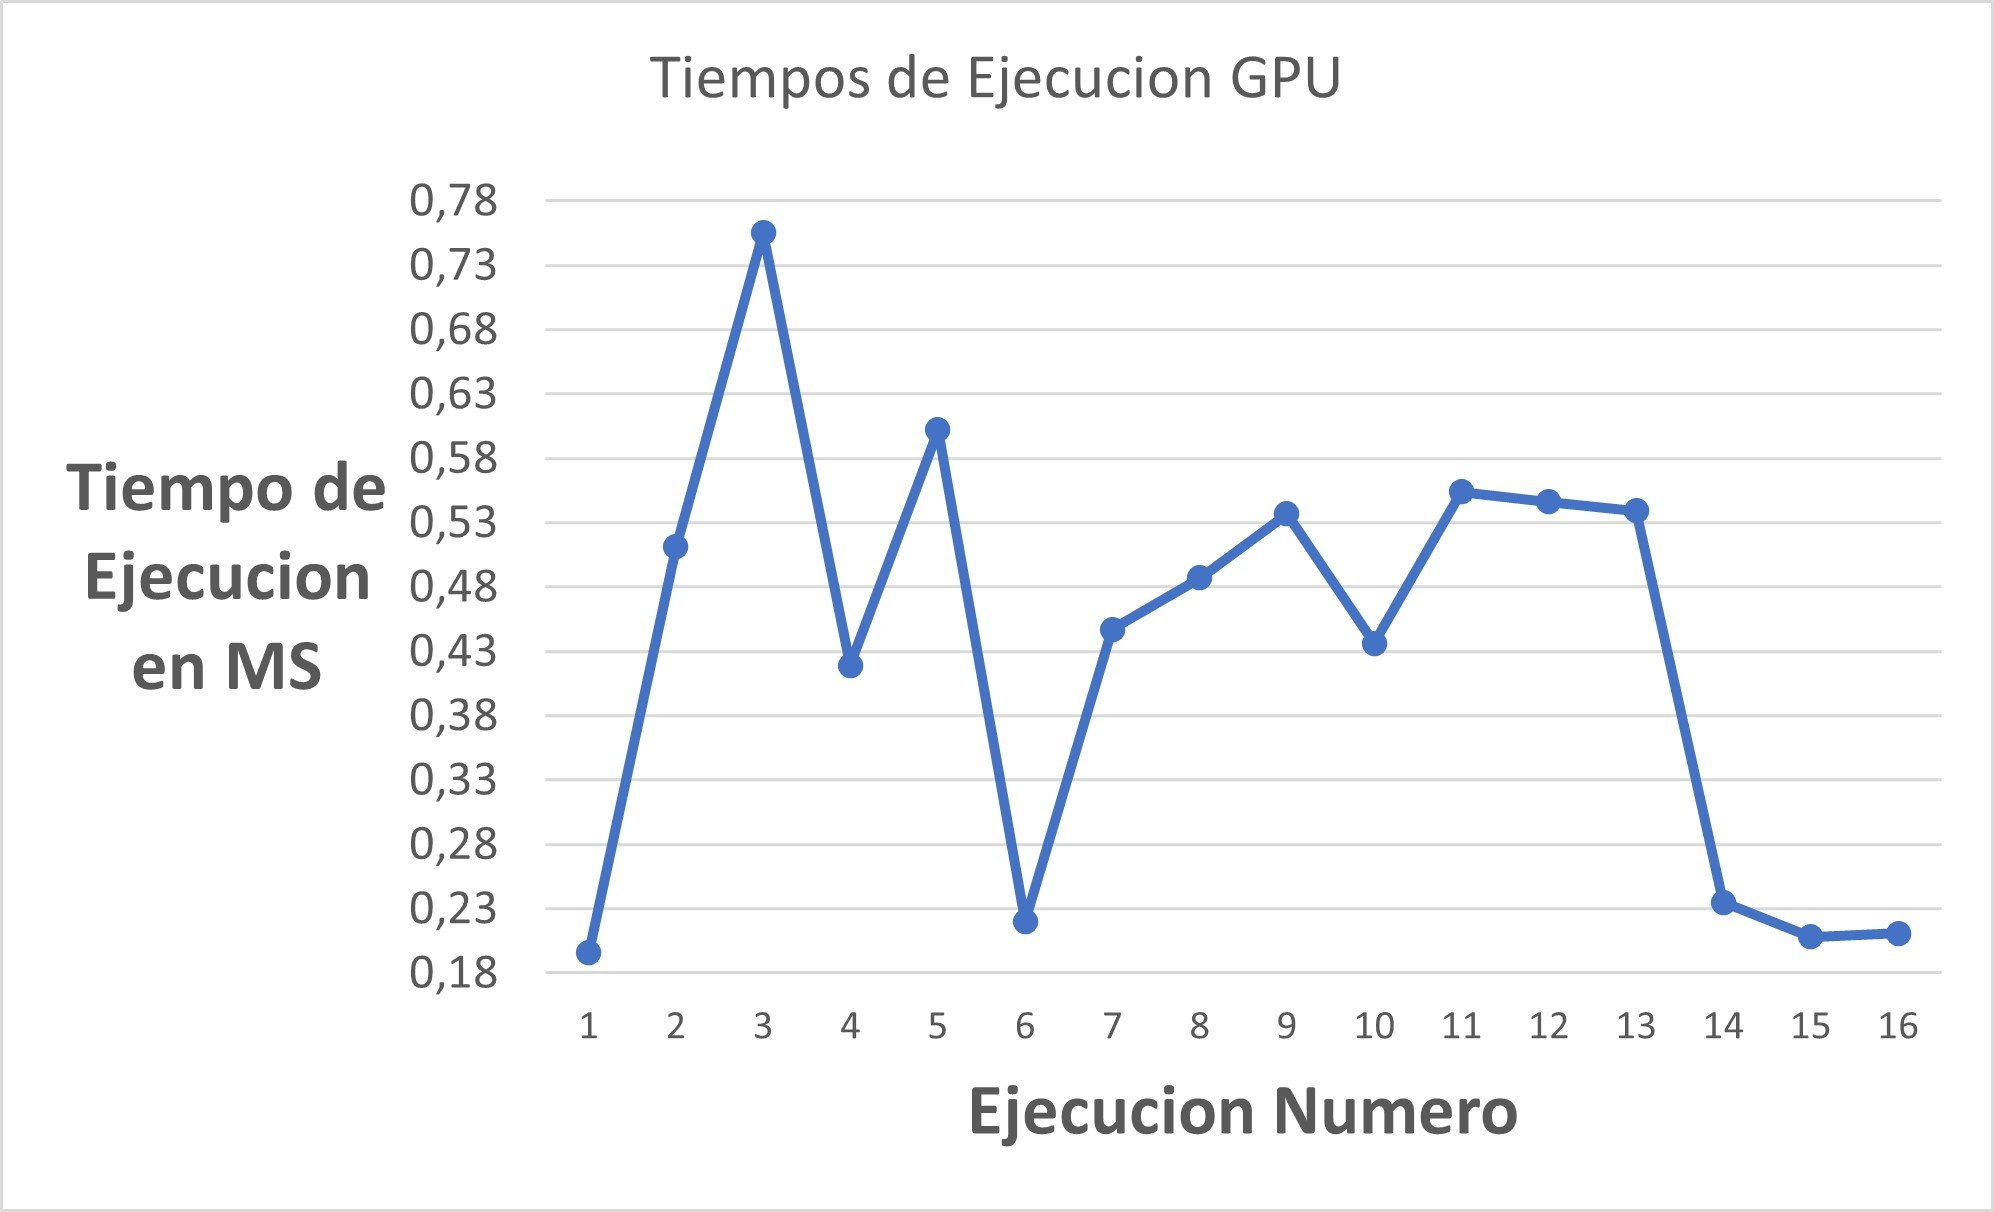

De esta forma realizar el algoritmo para obtener la cadena de ADN complementaria para una cadena de ADN muy grande se realizaria un 130% mas rapido que utilizando la CPU solamente. 



#6 Bibliografia
1 - Explicacion ADN: https://www.ncbi.nlm.nih.gov/books/NBK26821/

2 - Ejercicio Ejemplo Cadena ADN: https://www.youtube.com/watch?v=bcQQYsrGetM

3 - Informacion Cadenas ADN: https://es.wikipedia.org/wiki/Secuencia_de_ADN